In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


In [4]:
sns.set()

In [5]:
#df = pd.read_csv('imputed.csv')

## Impute + 1 hot encode

In [6]:
initial_df = pd.read_csv('HMEQ_Loss.csv')

In [7]:
#break into groups for initial run
numerical_columns = []
categorical_columns = []
other_cols = []

dt=initial_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (["object"]) : 
        categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        numerical_columns.append(i)
    else:
        other_cols.append(i)


In [8]:
#impute the categorical columns
#drop the originals
imputed_df = initial_df.copy()
for i in categorical_columns :
    if imputed_df[i].isna().sum() == 0: 
        continue
    NAME = "IMP_"+i
    imputed_df[NAME] = imputed_df[i]
    imputed_df[NAME] = imputed_df[NAME].fillna(imputed_df[NAME].mode()[0])
    print("variable",i," has this many missing", imputed_df[i].isna().sum())
    print("variable",NAME," has this many missing", imputed_df[NAME].isna().sum() ,'\n')
    g = imputed_df.groupby(NAME)
    print(g[NAME].count())
    print("\n\n")
    imputed_df = imputed_df.drop(i, axis=1)

variable REASON  has this many missing 252
variable IMP_REASON  has this many missing 0 

IMP_REASON
DebtCon    4180
HomeImp    1780
Name: IMP_REASON, dtype: int64



variable JOB  has this many missing 279
variable IMP_JOB  has this many missing 0 

IMP_JOB
Mgr         767
Office      948
Other      2667
ProfExe    1276
Sales       109
Self        193
Name: IMP_JOB, dtype: int64





In [9]:
#impute the numerical columns
#drop the originals
missing_flag_cols = []

for i in numerical_columns:
    if imputed_df[i].isna().sum() == 0:
        continue
    FLAG = 'M_' + i
    IMP = 'IMP_' + i
    imputed_df[FLAG] = imputed_df[i].isna() + 0
    missing_flag_cols.append(FLAG)
    imputed_df[IMP] = imputed_df[i]
    imputed_df.loc[imputed_df[IMP].isna(),IMP] = imputed_df[i].median()
    imputed_df = imputed_df.drop(i, axis=1)

In [10]:
#break into groups again with the dropped cols
imp_numerical_columns = []
imp_categorical_columns = []
imp_other_cols = []

dt=imputed_df.dtypes

TARGET_F = 'TARGET_BAD_FLAG'
TARGET_A = 'TARGET_LOSS_AMT'

for i in dt.index:
    if i in ([TARGET_A,TARGET_F]):
        continue
    elif dt[i] in (missing_flag_cols):
        imp_other_cols.append(i)
    elif dt[i] in (["object"]) : 
        imp_categorical_columns.append(i)
    elif dt[i] in (["float64"]) : 
        imp_numerical_columns.append(i)
    elif dt[i] in (["int64"]) : 
        imp_numerical_columns.append(i)
    else:
        imp_other_cols.append(i)

In [11]:
#now one hot encode the categorical columns
for i in imp_categorical_columns:
    prefix_name = 'z_' + i
    y = pd.get_dummies(imputed_df[i],prefix=prefix_name,drop_first=True)
    imputed_df = pd.concat([imputed_df,y],axis=1)
    imputed_df = imputed_df.drop(i,axis=1)


## Remove the outliers from the dataset


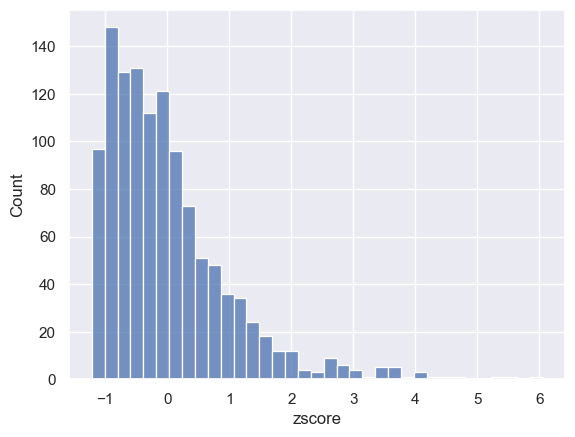

In [12]:
# from the imputed DF, let's keep only things within 3 standard deviations
# we'll use the scipy stats package to get the zscore
outlier_vis = imputed_df.copy()
outlier_vis['zscore'] = stats.zscore(outlier_vis[TARGET_A],nan_policy='omit')

# histogram of zscore
plot1 = sns.histplot(x=outlier_vis['zscore'], data=outlier_vis)
fig = plot1.get_figure()
fig.savefig('zscore_hist.png', bbox_inches='tight')
# get the absolute value of the zscore so we don't have to do > & < to get both upper and lower
# then save that as another df to use later on
# super important here is the or statement in filtering the df
# if you don't use the or part, you end up dropping all the nondefaults
imputed_no_outlier = imputed_df[(np.abs(stats.zscore(imputed_df[TARGET_A],nan_policy='omit')) < 3)\
                                 | ~imputed_df[TARGET_F].isna()].copy()

## Split the Data Into Test & Train

In [13]:
# drop the targets
# keep the predictors
# drop the missing flags as well
# uncomment to use no outlier
X = imputed_no_outlier.copy()
#X = imputed_df.copy()
X = X.drop(TARGET_F,axis=1)
X = X.drop(TARGET_A,axis=1)

for column in imputed_no_outlier.columns.values:
    if "M_" in column:
        X.drop(column,axis=1,inplace=True)

# the target we're predicting
Y = imputed_no_outlier[[TARGET_F,TARGET_A]]

# keep 80% for training
# keep 20% for testing
# use random_state=1 if you need the results to be the same (this sets our seed)
# X_train and Y_train should match up on the index
# X_test and Y_test should match up on the index
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, \
                                                    train_size=0.8, \
                                                    test_size=.2) #random_state=1

print("Training = ", X_train.shape)
print("Testing = ", X_test.shape)

Training =  (4768, 16)
Testing =  (1192, 16)


## Feature Selection

### Stepwise

In [14]:
# create a list of the columns
varNames = list(X.columns.values)

# define the max number of columns as the max number of current columns
maxCols = X.shape[1]

In [ ]:
sfs = SFS(LinearRegression(),
          k_features = (1, maxCols),
          forward = True,
          floating = False,
          scoring = 'r2',
          cv = 5)
sfs.fit(X.values,Y.values)